# An Introduction to Pennylane 

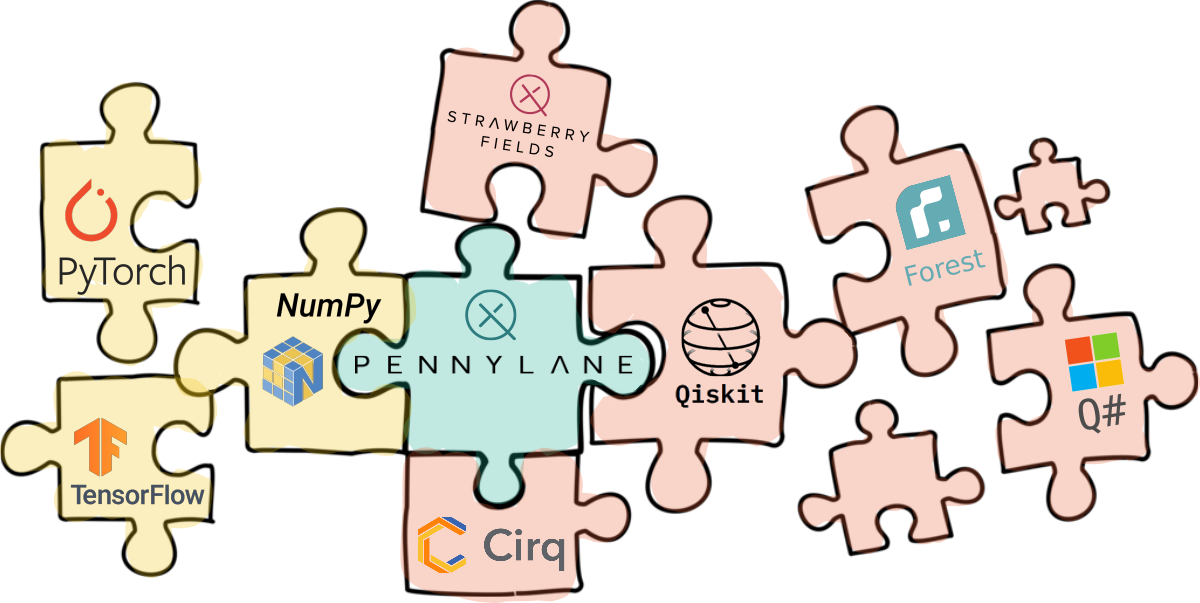

In our previous tutorials, we explored the Qiskit Programming language where we did projects from Shor's algorithm to quantum random number generators. In this tutorial, we will explore the Pennylane Framework- which is an open source software development kit built upon the idea of differentiable programming. We will do some basic tasks in Pennylane and highlight its future potential for quantum machine learning applications and optimization tasks and variational classifiers.

PennyLane works by integrating machine learning libraries with quantum simulators and hardware, giving users the power to train quantum circuits. Pennylane is written in Python, so if you know Qiskit, it is not that hard to learn about PennyLane. Classical computations,optimization or training of models, are executed using the standard scientific computing or machine learning libraries such as SciPy in Python. PennyLane provides an interface to these libraries and integrates these with quantum simulators to provide an interface between classical and quantum computing.

PennyLane’s uses NumPy to perform computations, but connects with machine learning libraries like PyTorch and Tensorflow for writing programs.PennyLane is built with default simulator devices, and connected with external software and hardware to run quantum circuits like IBM’s Qiskit, or Google’s Cirq.

The main advantage of using PennyLane is to control and manipulate parametrized quantum circuits or variational circuits on quantum devices, and if we use PennyLane we can easy feed these circuits to quantum neural networks. Using PennyLane, we can easily find and operate gradients of quantum circuits, which is essential for the machine learning package to perform backpropagation.


To install PennyLane, you must have a version of Python installed. Then run the following command

pip install pennylane --upgrade

### Quantum Circuits 

Quantum computations are represented as quantum node objects in PennyLane. A quantum node is an initialization of the quantum circuit, and encapsulates the computation to the specific quantum device that executes the circuit. Quantum nodes can be easily created by using the qnode decorator.

QNodes can interact with machine learning libraries such as PyTorch and TensorFlow. This is what allows it to connect the quantum circuit to data structures like TensorFlow tensors and optimizers. By default, QNodes use the NumPy interface.

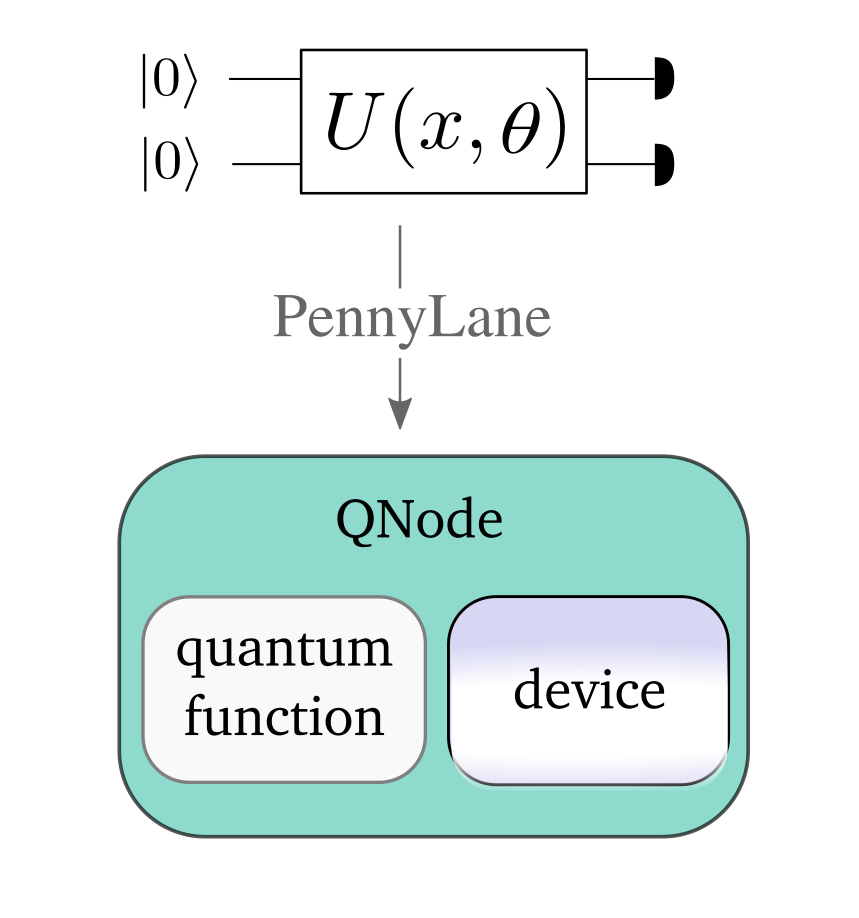

A quantum circuit is created using the syntax below

In [1]:
import pennylane as qml

def quantum_function(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(y, wires=1)
    return qml.expval(qml.PauliZ(1))

Instead of the qubit, PennyLane uses the term wires to refer to a quantum subsystem. The quantum function returns either a single or a tuple of measured observable values, by applying a measurement function, which in the function abive is the PauliZ operator to the qubit 1

To run and optimize a quantum circuit, we need to specify the quantum device on which to execute the circuit. The device is an instance or object of the Device class. It is instantiated using the device loader as follows

In [2]:
dev = qml.device('default.qubit', wires=2, shots=1000, analytic=False)

The name of the device is the first argument, wires represent the number of subsystems represented by the device, analytic indicates if the device should calculate expectations and variances analytically and shots indictate how many times the circuit should be evaluated to calculate the expectation values


### Creating a quantum node 

A quantum function is used to create a quantum node or QNode object, which encapsulates the quantum function and the device used to execute the function

A QNode is initialized as follows:

In [3]:
circuit = qml.QNode(quantum_function, dev)

The QNode is used to compute the result of a quantum circuit and can calculate results classically. For example, we will run the results of the quantum_function by creating a QNode circuit and passing the parameters x and y in the function quantum_function. Then an RZ gate, CNOT and RY will be applied on the circuit

In [4]:
import numpy as np
circuit(np.pi/3, 0.5)

tensor(0.862, requires_grad=True)

In [5]:
print(circuit.draw())

 0: ──RZ(1.05)──╭C───────────┤     
 1: ────────────╰X──RY(0.5)──┤ ⟨Z⟩ 



As we can see above, an RZ gate followed by a CX gate and RY gate is applied

### Building a Variational Classifier 

We will now use the quantum circuit and QNode to build a variational classifier in PennyLane. Variational circuits are circuits that can be trained using supervised learning or labelled data to classify new data.

The Variational Circuit can be implemented using the Parity Function

$ f:x\in{\{0,1\}}^ {\otimes{n}}\rightarrow{y}=$ 1 if uneven number of 1's in $x$, 0 otherwise

We will first import the required libraries

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

### Step 1: Create a quantum device with 2 wires 

In [7]:
dev = qml.device("default.qubit", wires=2)

Variational classifiers define “layer” or “block", elementary circuit architecture that gets repeated to build the variational circuit.

Our circuit layer consists of an rotations on every qubit, as well as CNOTs that create entanglement. The rotation function is represented by qml.Rot(phi, theta, omega, wires). By applying the qml.Rot() function, an arbitary single qubit rotation is applied

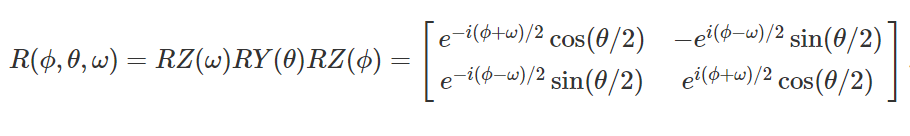

In [8]:
def variational_layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

For encoding data inputs into the circuit, we need to encode the inputs into the state of the qubits. The quantum state $|\psi\rangle$ is prepared using a computational basis state. The BasisState function is used which encodes the input into a quantum state. The input should be a list of zeros and ones.

In [9]:
def quantum_state(x):
    qml.RY(x[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[4], wires=1)
    qml.PauliX(wires=0)

Now, the quantum node is prepared by using the weights as parameters

In [10]:
@qml.qnode(dev)
def circuit(weights, angles):
    quantum_state(angles)

    for W in weights:
        variational_layer(W)

    return qml.expval(qml.PauliZ(0))

The variational classifier will return the circuit of the weights+bias, similar to classical machine learning

In [11]:
def variational_classifier(var, x):
    weights = var[0]
    bias = var[1]
    return circuit(weights, x) + bias

The cost function is the sum of the loss function and a regularizer. This loss function is used during training to measure the distance between target labels and model prediction using the square loss function

In [12]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

The accuracy can be determined given how many predictions were correct

In [13]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

We will know build a variational classifier on the Iris dataset. We will do preprocessing to encode the inputs into the amplitudes of a quantum state. Every input x has to be translated into a set of rotation angles

The circuit is coded according to the algorithm in this paper https://arxiv.org/abs/quant-ph/0407010

In [14]:
def angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [15]:
import pennylane as qml
import numpy as np
dev = qml.device("default.qubit", wires=2)

In [16]:

def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

### Step 2: Normalize the data 

In [17]:
data = np.loadtxt("data/data.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("Padded Input   :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("Normalized input:", X_norm[0])

# state preparation angles
features = np.array([angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
Padded Input   : [0.4  0.75 0.3  0.  ]
Normalized input: [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


### Step 3: Split the data into training and validation set 

In [18]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

### Step 4: Optimize the cost 

In [19]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4490948 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3309953 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1582178 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9795035 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 0.8857893 | Acc train: 0.6400000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8587935 | Acc train: 0.7066667 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.8496204 | Acc train: 0.7200000 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8200972 | Acc train: 0.7333333 | Acc validation: 0.6800000 
Iter:     9 | Cost: 0.8027511 | Acc train: 0.7466667 | Acc validation: 0.6800000 
Iter:    10 | Cost: 0.7695152 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.7437432 | Acc train: 0.8133333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.7569196 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:    13 | Co

### Step 5: Plot the graphs of the output of the variational classifier

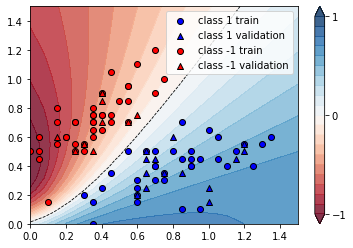

In [23]:
import matplotlib.pyplot as plt
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()